This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pezhmanla","key":"46e94d6db3a453bc53a74bcb7717f876"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:35<00:00, 21.6MB/s]
100% 812M/812M [00:35<00:00, 24.1MB/s]


In [7]:
!unzip -qq dogs-vs-cats.zip

In [9]:
!unzip -qq train.zip

replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [10]:
!unzip -qq test1.zip

**Copying images to training, validation, and test directories**

In [11]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=2500)
make_subset("validation", start_index=2500, end_index=3000)
make_subset("test", start_index=3000, end_index=3500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [15]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [16]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 5000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [17]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [18]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [19]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [20]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [21]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 20s 63ms/step - loss: 0.7042 - accuracy: 0.5398 - val_loss: 0.6776 - val_accuracy: 0.5290
Epoch 2/30
157/157 [==============================] - 10s 60ms/step - loss: 0.6580 - accuracy: 0.6294 - val_loss: 0.6840 - val_accuracy: 0.5710
Epoch 3/30
157/157 [==============================] - 10s 60ms/step - loss: 0.5931 - accuracy: 0.6896 - val_loss: 0.5962 - val_accuracy: 0.6970
Epoch 4/30
157/157 [==============================] - 10s 61ms/step - loss: 0.5501 - accuracy: 0.7188 - val_loss: 0.5943 - val_accuracy: 0.6810
Epoch 5/30
157/157 [==============================] - 10s 60ms/step - loss: 0.4970 - accuracy: 0.7602 - val_loss: 0.5764 - val_accuracy: 0.7070
Epoch 6/30
157/157 [==============================] - 10s 60ms/step - loss: 0.4493 - accuracy: 0.7934 - val_loss: 0.6373 - val_accuracy: 0.6920
Epoch 7/30
157/157 [==============================] - 10s 60ms/step - loss: 0.3958 - accuracy: 0.8170 - val_loss: 0.5815 - val_accuracy:

**Displaying curves of loss and accuracy during training**

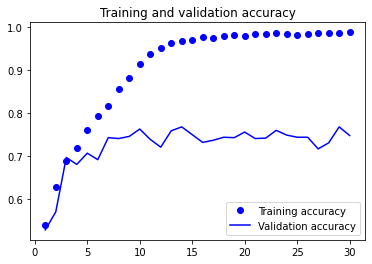

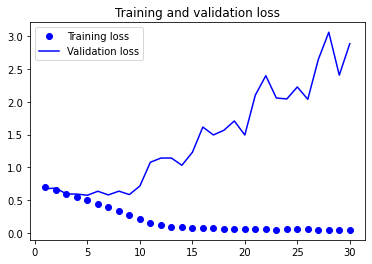

In [23]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [24]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.5360 - accuracy: 0.7470
Test accuracy: 0.747


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [25]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

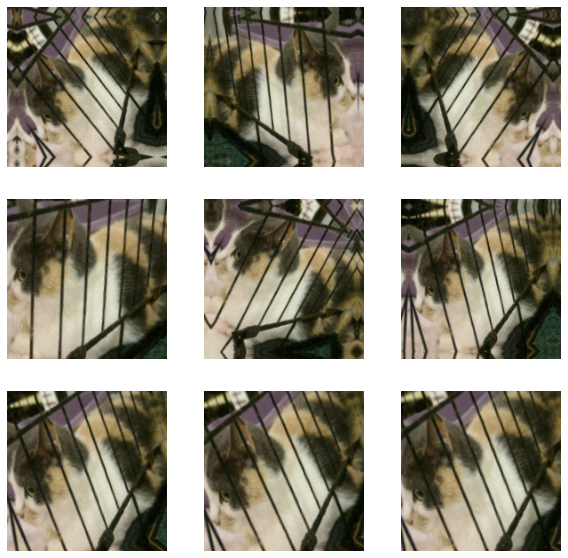

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
157/157 [==============================] - 15s 85ms/step - loss: 0.7162 - accuracy: 0.5220 - val_loss: 0.6927 - val_accuracy: 0.5260
Epoch 2/100
157/157 [==============================] - 14s 84ms/step - loss: 0.6784 - accuracy: 0.5860 - val_loss: 0.6521 - val_accuracy: 0.6180
Epoch 3/100
157/157 [==============================] - 13s 84ms/step - loss: 0.6487 - accuracy: 0.6420 - val_loss: 0.6765 - val_accuracy: 0.6110
Epoch 4/100
157/157 [==============================] - 14s 85ms/step - loss: 0.6196 - accuracy: 0.6634 - val_loss: 0.6021 - val_accuracy: 0.6740
Epoch 5/100
157/157 [==============================] - 13s 83ms/step - loss: 0.5873 - accuracy: 0.6976 - val_loss: 0.7808 - val_accuracy: 0.5660
Epoch 6/100
157/157 [==============================] - 14s 84ms/step - loss: 0.5712 - accuracy: 0.7082 - val_loss: 0.5700 - val_accuracy: 0.7060
Epoch 7/100
157/157 [==============================] - 13s 84ms/step - loss: 0.5617 - accuracy: 0.7220 - val_loss: 0.5766 - val_ac

**Evaluating the model on the test set**

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 34ms/step - loss: 0.3377 - accuracy: 0.9050
Test accuracy: 0.905


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [30]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [32]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [33]:
train_features.shape

(5000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [34]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 1s 6ms/step - loss: 11.6778 - accuracy: 0.9458 - val_loss: 17.0924 - val_accuracy: 0.9230
Epoch 2/20
157/157 [==============================] - 1s 5ms/step - loss: 3.5988 - accuracy: 0.9770 - val_loss: 6.9811 - val_accuracy: 0.9580
Epoch 3/20
157/157 [==============================] - 1s 6ms/step - loss: 1.7611 - accuracy: 0.9882 - val_loss: 5.9126 - val_accuracy: 0.9760
Epoch 4/20
157/157 [==============================] - 1s 5ms/step - loss: 1.3772 - accuracy: 0.9912 - val_loss: 9.3196 - val_accuracy: 0.9570
Epoch 5/20
157/157 [==============================] - 1s 6ms/step - loss: 0.8141 - accuracy: 0.9922 - val_loss: 5.3247 - val_accuracy: 0.9730
Epoch 6/20
157/157 [==============================] - 1s 5ms/step - loss: 0.8882 - accuracy: 0.9930 - val_loss: 6.5294 - val_accuracy: 0.9730
Epoch 7/20
157/157 [==============================] - 1s 5ms/step - loss: 0.6645 - accuracy: 0.9942 - val_loss: 5.7273 - val_accuracy: 0.9770
Epoc

**Plotting the results**

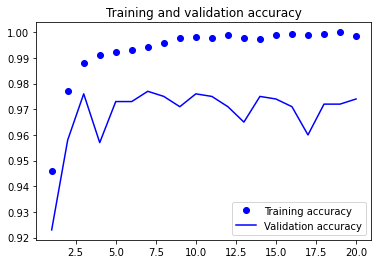

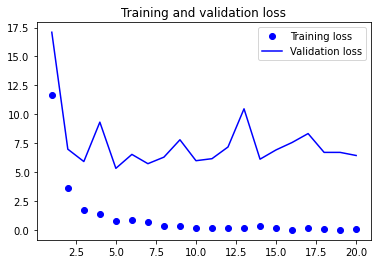

In [35]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [36]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [37]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [38]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [39]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
157/157 [==============================] - 28s 170ms/step - loss: 11.0445 - accuracy: 0.9242 - val_loss: 5.6479 - val_accuracy: 0.9550
Epoch 2/50
157/157 [==============================] - 26s 167ms/step - loss: 6.7893 - accuracy: 0.9476 - val_loss: 10.6623 - val_accuracy: 0.9470
Epoch 3/50
157/157 [==============================] - 26s 164ms/step - loss: 5.2912 - accuracy: 0.9580 - val_loss: 4.3900 - val_accuracy: 0.9700
Epoch 4/50
157/157 [==============================] - 26s 167ms/step - loss: 3.8002 - accuracy: 0.9622 - val_loss: 3.8294 - val_accuracy: 0.9750
Epoch 5/50
157/157 [==============================] - 26s 166ms/step - loss: 2.8979 - accuracy: 0.9646 - val_loss: 3.3188 - val_accuracy: 0.9700
Epoch 6/50
157/157 [==============================] - 26s 167ms/step - loss: 2.4133 - accuracy: 0.9630 - val_loss: 1.9681 - val_accuracy: 0.9770
Epoch 7/50
157/157 [==============================] - 26s 166ms/step - loss: 1.5708 - accuracy: 0.9708 - val_loss: 3.6683 - val_

**Evaluating the model on the test set**

In [41]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 117ms/step - loss: 0.4821 - accuracy: 0.9790
Test accuracy: 0.979


### Fine-tuning a pretrained model

In [42]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [43]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [44]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 32s 190ms/step - loss: 0.4899 - accuracy: 0.9834 - val_loss: 2.0238 - val_accuracy: 0.9700
Epoch 2/30
157/157 [==============================] - 30s 187ms/step - loss: 0.3039 - accuracy: 0.9878 - val_loss: 1.7194 - val_accuracy: 0.9700
Epoch 3/30
157/157 [==============================] - 30s 187ms/step - loss: 0.4146 - accuracy: 0.9832 - val_loss: 1.7113 - val_accuracy: 0.9730
Epoch 4/30
157/157 [==============================] - 29s 186ms/step - loss: 0.2305 - accuracy: 0.9876 - val_loss: 1.8418 - val_accuracy: 0.9680
Epoch 5/30
157/157 [==============================] - 30s 187ms/step - loss: 0.3744 - accuracy: 0.9878 - val_loss: 1.7236 - val_accuracy: 0.9670
Epoch 6/30
157/157 [==============================] - 30s 189ms/step - loss: 0.2301 - accuracy: 0.9876 - val_loss: 1.3497 - val_accuracy: 0.9710
Epoch 7/30
157/157 [==============================] - 29s 183ms/step - loss: 0.1993 - accuracy: 0.9898 - val_loss: 1.4997 - val_ac

In [45]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 113ms/step - loss: 0.8118 - accuracy: 0.9860
Test accuracy: 0.986


## Summary